In [2]:
%matplotlib ipympl
from impedance.models.circuits.elements import element
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy
import matplotlib.pyplot as plt

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.559555194837311e-15
       x: [ 1.000e+02]
     nit: 3
     jac: [ 2.958e-08]
    nfev: 18
    njev: 9
 allvecs: [array([ 1.000e+01]), array([ 9.585e+01]), array([ 1.000e+02]), array([ 1.000e+02])]


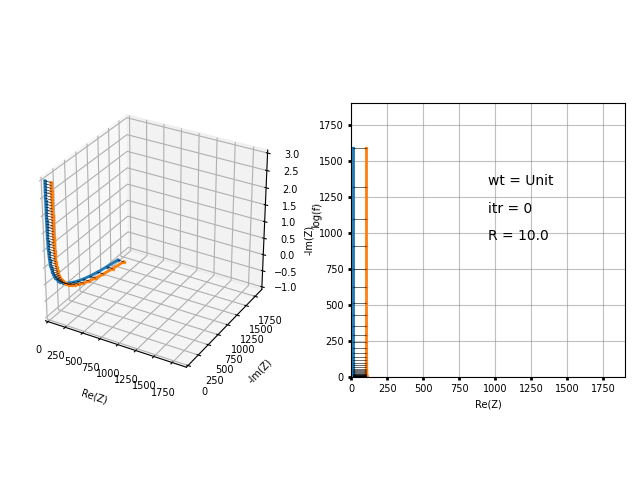

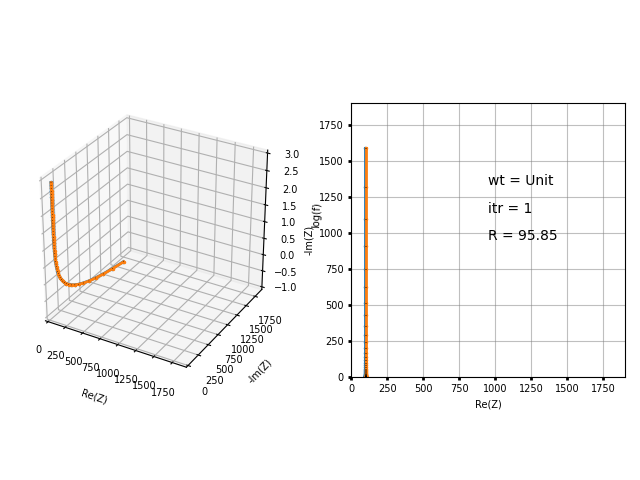

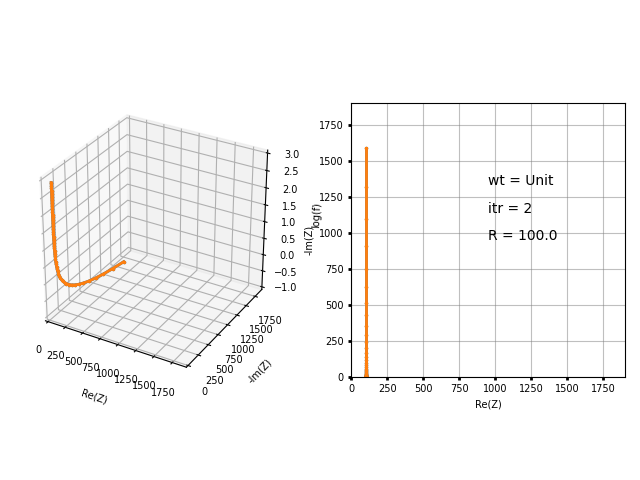

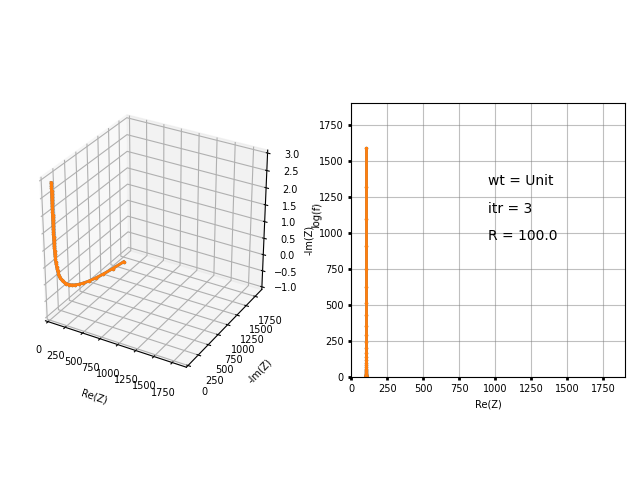

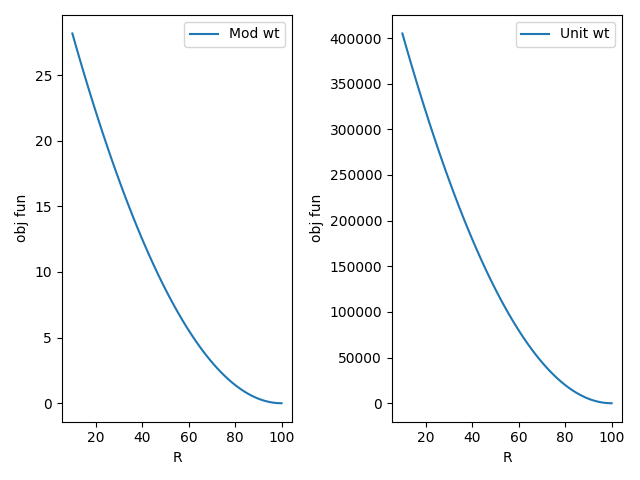

In [4]:
freq_list=np.logspace(-1,3,50)
circuit="R_1-C_1"
# c = CustomCircuit(initial_guess=[1],circuit=circuit,constants={"R_1":100,"CPE_1_0":1e-3})
c = CustomCircuit(initial_guess=[100],circuit=circuit,constants={"C_1":1e-3})
z_exp=c.predict(frequencies=freq_list)

from scipy.optimize import minimize, least_squares


omega=2*np.pi*freq_list

def fun(params,omega,z_exp,weights):
    # R=params[0]
    R=params[0]
    # alpha=params[1]
    # R0=100 
    # C0=1e-3
    # R0=1 
    # C0=1
    chi_total=0
    for w,z,wt in zip(omega,z_exp,weights):
        # c = CustomCircuit(initial_guess=[alpha],circuit=circuit,constants={"R_1":100,"CPE_1_0":1e-3})
        # c = CustomCircuit(initial_guess=[Q,alpha],circuit=circuit,constants={"R_1":100})
        c = CustomCircuit(initial_guess=[R],circuit=circuit,constants={"C_1":1e-3})
        z_model=c.predict(frequencies=[w/(2*np.pi)])
        chi_real=(np.real(z_model)-np.real(z))**2/wt**2
        chi_imag=(np.imag(z_model)-np.imag(z))**2/wt**2
        chi_total+=(chi_real+chi_imag)

    return chi_total

## weighing ##
# wt=np.abs(z_exp)
wt=np.ones(len(z_exp))
# wt=omega

result=minimize(fun,(10),args=(omega,z_exp,wt),method="CG",options={'return_all': True})
print(result)

# result2=least_squares(fun,(100,2e-3),args=(omega,z_exp,wt))


# cc = CustomCircuit(initial_guess=[result.x[0],result.x[1]],circuit=circuitrq,constant={"R_1":100})
# z_fit = cc.predict(frequencies=freq_list)

itr=0

for sol in result.allvecs:
    # cc = CustomCircuit(initial_guess=[sol[0]],circuit=circuit,constants={"R_1":100,"CPE_1_0":1e-3})
    cc = CustomCircuit(initial_guess=[sol[0]],circuit=circuit,constants={"C_1":1e-3})
    z_fit = cc.predict(frequencies=freq_list)   
    fig=plt.figure()
    ax1=fig.add_subplot(121,projection="3d")
    ax1.tick_params(direction='out', length=6, width=2, colors='k',grid_color='k', grid_alpha=0.5,size=2,labelsize=7)
    ax2=fig.add_subplot(122)
    ax2.tick_params(direction='out', length=6, width=2, colors='k',grid_color='k', grid_alpha=0.5,size=2,labelsize=7)
    ax1.set_box_aspect([1,1,1])
    ax1.set_xlim(0,1900)
    ax1.set_ylim(0,1900)
    ax2.set_xlim(0,1900)
    ax2.set_ylim(0,1900)
    ax1.set_xlabel("Re(Z)",fontsize=7)
    ax1.set_ylabel("-Im(Z)",fontsize=7)
    ax1.set_zlabel("log(f)",fontsize=7)
    ax2.set_xlabel("Re(Z)",fontsize=7)
    ax2.set_ylabel("-Im(Z)",fontsize=7)
    ax2.set_aspect("equal")
    ax2.grid(True,color="grey")
    #plot the 3D plot exp and model
    ax1.plot(np.real(z_fit),-np.imag(z_fit),np.log10(freq_list),".",ms=3,linestyle="-",label="Fit",linewidth=2)
    ax1.plot(np.real(z_exp),-np.imag(z_exp),np.log10(freq_list),".",ms=3,linestyle="-",label="Exp",linewidth=2)
    #plot the 2D plot exp vs model
    ax2.plot(np.real(z_fit),-np.imag(z_fit),".",ms=3,linestyle="-",label="Fit",linewidth=2)
    ax2.plot(np.real(z_exp),-np.imag(z_exp),".",ms=3,linestyle="-",label="Exp",linewidth=2)
    ax2.text(0.5,0.5,f"R = {round(sol[0],3)}",transform = ax2.transAxes) 
    ax2.text(0.5,0.6,f"itr = {itr}",transform = ax2.transAxes) 
    ax2.text(0.5,0.7,"wt = Unit",transform = ax2.transAxes) 
    for p1,p2,f in zip(z_exp,z_fit,freq_list):
        ax1.plot([np.real(p1),np.real(p2)],[-np.imag(p1),-np.imag(p2)],[np.log10(f),np.log10(f)],color="black",linestyle="-",linewidth=0.4)
        ax2.plot([np.real(p1),np.real(p2)],[-np.imag(p1),-np.imag(p2)],color="black",linestyle="-",linewidth=0.4)
    plt.tight_layout()
    itr+=1

fig2, [axx1,axx2]=plt.subplots(1,2)
xx=np.linspace(10,100,100)
fun_val1=[]
# print("Val of obj fun",fun([0.96],omega=omega,z_exp=z_exp,weights=wt))
for x in xx:
    fun_val1.append(fun([x],omega=omega,z_exp=z_exp,weights=np.abs(z_exp)))

fun_val1=np.asarray(fun_val1)
axx1.plot(xx,fun_val1,label="Mod wt")
axx1.set_xlabel("R")
axx1.set_ylabel("obj fun")
axx1.legend()

fun_val2=[]
for x in xx:
    fun_val2.append(fun([x],omega=omega,z_exp=z_exp,weights=np.ones(len(z_exp))))
axx2.plot(xx,fun_val2,label="Unit wt")
axx2.set_xlabel("R")
axx2.set_ylabel("obj fun")
axx2.legend()
fig2.tight_layout()